In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import xgboost as xgb
from xgboost import plot_importance
%matplotlib inline

print('loading aisles...')
aisles = pd.read_csv('aisles.csv', dtype={
        'aisle_id': np.uint16,
        'aisle': 'category'})

print('loading department...')
department = pd.read_csv('departments.csv', dtype={
            'department_id': np.uint8,
            'department': 'category'})

print('loading products...')
products = pd.read_csv('products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.uint32,
        'aisle_id': np.uint8,
        'department_id': np.uint8})

print('loading prior orders...')
prior = pd.read_csv('order_products__prior.csv', dtype={
        'order_id': np.uint32,
        'product_id': np.uint16,
        'add_to_cart_order': np.uint16,
        'reordered': np.uint16})

print('loading train orders...')
train = pd.read_csv('order_products__train.csv', dtype={
        'order_id': np.uint32,
        'product_id': np.uint16,
        'add_to_cart_order': np.uint16,
        'reordered': np.uint8})

print('loading orders...')
order = pd.read_csv('orders.csv' , dtype={
        'order_id': np.uint32,
        'user_id': np.uint32,
        'eval_set': 'category',
        'order_number': np.uint16,
        'order_dow': np.uint16,
        'order_hour_of_day': np.uint16,
        'days_since_prior_order': np.float32})

# print('loading None products in prior')
# prior_None = pd.read_csv('None_order_prior_.csv', dtype={
#             'order_id': np.uint32,
#             'product_id': np.uint16,
#             'add_to_cart_order': np.uint16,
#             'reordered': np.uint16})

# print('loading None products in train')
# train_None = pd.read_csv('None_order_train_.csv', dtype={
#             'order_id': np.uint32,
#             'product_id': np.uint16,
#             'add_to_cart_order': np.uint16,
#             'reordered': np.uint16})


loading aisles...
loading department...
loading products...
loading prior orders...
loading train orders...
loading orders...


In [2]:
# prior = pd.concat([prior, prior_None], ignore_index = True)
# train = pd.concat([train, train_None], ignore_index = True)

In [3]:
# order.set_index('order_id', inplace=True, drop=False)
# reorder_info = pd.DataFrame()
# reorder_info['order_id'] = prior.groupby(prior.order_id)['order_id'].apply(lambda x: x.iloc[0])
# reorder_info['user_id'] = reorder_info.order_id.map(order.user_id)
# reorder_info['nb_reorder'] = prior.groupby(prior.order_id)['reordered'].sum().astype(np.uint8)
# reorder_info['last_add_to_cart_order'] = prior.groupby(prior.order_id)['add_to_cart_order'].max()
# reorder_info['order_number'] = reorder_info.order_id.map(order.order_number)
# none_order_id = np.array(reorder_info.order_id[reorder_info.nb_reorder == 0])
# d = dict()
# d['order_id'] = []
# d['product_id'] = []
# d['add_to_cart_order'] = []
# d['reordered'] = []
# count=0
# for k in none_order_id:
#     count+=1
#     if not count % 10000:
#         print("%d orders" % count)
#     order_number = np.array(order.order_number[order.order_id == k])[0]
#     if order_number > 1: # 第一个order不要
#         d['order_id'].append(k)
#         d['product_id'].append(49689)
#         d['add_to_cart_order'].append(np.array(reorder_info.last_add_to_cart_order[reorder_info.order_id==k])[0] + 1)
#         if order_number == 2: # 第二个order不算reorder
#             d['reordered'].append(0)
#         else:
#             user_id = np.array(reorder_info.user_id[reorder_info.order_id==k])[0]
#             user_orders = order[order.user_id==user_id]
#             last_order_id = np.array(user_orders.order_id[user_orders.order_number == (order_number - 1)])[0]
#             if np.array(reorder_info.nb_reorder[reorder_info.order_id==last_order_id])[0] == 0:
#                 d['reordered'].append(1)
#             else:
#                 d['reordered'].append(0)
# tmp = pd.DataFrame()
# tmp['order_id'] = d['order_id']
# tmp['product_id'] = d['product_id']
# tmp['add_to_cart_order'] = d['add_to_cart_order']
# tmp['reordered'] = d['reordered']
# tmp.to_csv('None_order_prior.csv', index=False)
# reorder_info_train = pd.DataFrame()
# reorder_info_train['order_id'] = train.groupby(train.order_id)['order_id'].apply(lambda x: x.iloc[0])
# reorder_info_train['user_id'] = reorder_info_train.order_id.map(order.user_id)
# reorder_info_train['nb_reorder'] = train.groupby(train.order_id)['reordered'].sum().astype(np.uint8)
# reorder_info_train['last_add_to_cart_order'] = train.groupby(train.order_id)['add_to_cart_order'].max()
# reorder_info_train['order_number'] = reorder_info_train.order_id.map(order.order_number)
# none_order_id_train = np.array(reorder_info_train.order_id[reorder_info_train.nb_reorder == 0])

# d = dict()
# d['order_id'] = []
# d['product_id'] = []
# d['add_to_cart_order'] = []
# d['reordered'] = []
# count=0
# for k in none_order_id_train:
#     count+=1
#     if not count % 10000:
#         print("%d orders" % count)
#     order_number = np.array(order.order_number[order.order_id == k])[0]
#     d['order_id'].append(k)
#     d['product_id'].append(49689)
#     d['add_to_cart_order'].append(np.array(reorder_info_train.last_add_to_cart_order[reorder_info_train.order_id==k])[0] + 1)
#     user_id = np.array(reorder_info_train.user_id[reorder_info_train.order_id==k])[0]
#     user_orders = order[order.user_id==user_id]
# #     display(user_orders)
#     last_order_id = np.array(user_orders.order_id[user_orders.order_number == (order_number - 1)])[0]
#     if np.array(reorder_info.nb_reorder[reorder_info.order_id==last_order_id])[0] == 0:
#         d['reordered'].append(1)
#     else:
#         d['reordered'].append(0)
# tmp = pd.DataFrame()
# tmp['order_id'] = d['order_id']
# tmp['product_id'] = d['product_id']
# tmp['add_to_cart_order'] = d['add_to_cart_order']
# tmp['reordered'] = d['reordered']
# tmp.to_csv('None_order_train.csv', index=False)

In [2]:
# best sellers
best_seller_id = [24852, 13176, 21137, 21903, 47626, 47766, 47209, 16797, \
                 26209, 27966]
most_often_reordered = [1729, 20940, 12193, 21038, 31764, 24852, 117, \
                       39180, 12384, 24024]

In [3]:
train_orders = order[order.eval_set == 'train']
test_orders = order[order.eval_set == 'test']
prior_orders = order[order.eval_set == 'prior']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

order.set_index('order_id', inplace=True, drop=False)
prior = prior.join(order, on='order_id', rsuffix='_')
prior.drop('order_id_', inplace=True, axis=1)
prior.set_index('order_id', inplace=True, drop=False)

In [4]:
print('Construct products information...')
prods = pd.DataFrame()
prods['total_nb'] = prior.groupby(prior.product_id).size().astype(np.uint32)
prods['nb_reorder'] = prior.groupby(prior.product_id)['reordered'].sum().astype(np.uint32)
prods['reorder_rate'] = prods.nb_reorder / prods.total_nb.astype(np.float32)
prods['nb_buyers'] = prior.groupby(prior.product_id)['user_id'].apply(lambda x: len(set(x))).astype(np.uint16) # unique buyers
prods['avg_add_to_cart_order'] = prior.groupby(prior.product_id)['add_to_cart_order'].mean().astype(np.uint8)
prods['min_add_to_cart_order'] = prior.groupby(prior.product_id)['add_to_cart_order'].min().astype(np.uint8)
prods['max_add_to_cart_order'] = prior.groupby(prior.product_id)['add_to_cart_order'].max().astype(np.uint8)
prods['nb_orders'] = prior.groupby(prior.product_id).size().astype(np.uint16)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)

Construct products information...


In [5]:
print('Order related information...')
ords_pri = pd.DataFrame()
ords_pri['order_id'] = prior.groupby(prior.order_id)['order_id'].apply(lambda x: x.iloc[0])
ords_pri['user_id'] = prior.groupby(prior.order_id)['user_id'].apply(lambda x: x.iloc[0])
ords_pri['unique_product_id'] = prior.groupby(prior.order_id)['product_id'].apply(set)
ords_pri['all_product_id'] = prior.groupby(prior.order_id)['product_id'].apply(list)
ords_pri.set_index('order_id', drop=False, inplace=True)
ords_pri['nb_items'] = prior.groupby(prior.order_id)['product_id'].size().astype(np.uint8)
ords_pri['first_item_id'] = prior.groupby(prior.order_id)['product_id'].apply(lambda x: x.iloc[0])
ords_pri['first_item_reorder'] = prior.groupby(prior.order_id)['reordered'].apply(lambda x: x.iloc[0])
ords_pri['nb_reorder'] = prior.groupby(prior.order_id)['reordered'].sum()
ords_pri['reorder_ratio'] = (ords_pri['nb_reorder'] / ords_pri['nb_items']).astype(np.float32)

Order related information...


In [6]:
print("min and max basket size for each user...")
min_basket_list = []
max_basket_list = []
avg_basket_list = []
nb_reorder_items_list = []
avg_reorder_per_basket_list = []
reorder_order_vs_order_ratio_list = []
nb_all_items_list = []
nb_reorder_items_vs_nb_all_items_ratio_list = []
min_reorder_items_list = []
max_reorder_items_list = []
unique_items_set = []
all_product_list = []
nb_unique_items_list = []
user_order_list = prior_orders.groupby('user_id')['order_id'].apply(list)
for ord_i, order_list in enumerate(user_order_list):
    if not (ord_i + 1) % 10000:
        print("%d orders..." % (ord_i+1))
    min_basket=999
    max_basket=0
    min_reorder_items = 999
    max_reorder_items = 0
    nb_reorder = 0
    nb_reorder_orders = 0
    nb_all_items = 0
    nb_order = len(order_list)
    all_product_list_tmp = []
    unique_items_tmp_set = set()
    for order_id in order_list:
        nb_item_s = ords_pri.loc[order_id, 'nb_items']
        nb_all_items += nb_item_s
        nb_reorder_s = ords_pri.loc[order_id, 'nb_reorder']
        nb_reorder += nb_reorder_s
        nb_reorder_orders += (ords_pri.loc[order_id, 'nb_reorder'] > 0).astype(np.uint8)
        min_basket = min(min_basket, nb_item_s)
        max_basket = max(max_basket, nb_item_s)
        min_reorder_items = min(min_reorder_items, nb_reorder_s)
        max_reorder_items = max(max_reorder_items, nb_reorder_s)
        unique_items_tmp_set |= ords_pri.loc[order_id, 'unique_product_id']
        all_product_list_tmp += ords_pri.loc[order_id, 'all_product_id']
    unique_items_set.append(list(unique_items_tmp_set))
    all_product_list.append(all_product_list_tmp)
    nb_unique_items_list.append(len(unique_items_set))
    avg_basket_list.append((nb_all_items / nb_order).astype(np.float32))
    min_basket_list.append(min_basket)
    max_basket_list.append(max_basket)
    nb_reorder_items_list.append(nb_reorder)
    avg_reorder_per_basket_list.append((nb_reorder / nb_order).astype(np.float32))
    reorder_order_vs_order_ratio_list.append((nb_reorder_orders / nb_order).astype(np.float32)) 
    nb_all_items_list.append(nb_all_items)
    nb_reorder_items_vs_nb_all_items_ratio_list.append((nb_reorder / nb_all_items).astype(np.float32))
    min_reorder_items_list.append(min_reorder_items)
    max_reorder_items_list.append(max_reorder_items)
#     print("order id: %d, min_basket: %d, max_basket: %d" %(order_id, min_basket, max_basket))

min and max basket size for each user...
10000 orders...
20000 orders...
30000 orders...
40000 orders...
50000 orders...
60000 orders...
70000 orders...
80000 orders...
90000 orders...
100000 orders...
110000 orders...
120000 orders...
130000 orders...
140000 orders...
150000 orders...
160000 orders...
170000 orders...
180000 orders...
190000 orders...
200000 orders...


In [7]:
train_orders.set_index('user_id', drop=False, inplace=True)
prior_orders.set_index('user_id', drop=False, inplace=True)

In [8]:
print('User related information')
users = pd.DataFrame()
users['user_id'] = prior.groupby('user_id')['user_id'].apply(lambda x: x.iloc[0])
users['nb_order'] = prior_orders.groupby(users.user_id).size().astype(np.uint16)
users['orders'] = prior_orders.groupby(users.user_id)['order_id'].apply(list) 
users['min_basket'] = min_basket_list
users['max_basket'] = max_basket_list
users['nb_reorder_items'] = nb_reorder_items_list
users['avg_reorder_per_basket'] = avg_reorder_per_basket_list
users['reorder_order_vs_order_ratio'] = reorder_order_vs_order_ratio_list
users['nb_all_items'] = nb_all_items_list
users['nb_reorder_items_vs_nb_all_items_ratio'] = nb_reorder_items_vs_nb_all_items_ratio_list
users['min_reorder_items'] = min_reorder_items_list
users['max_reorder_items'] = max_reorder_items_list
users['nb_unique_items'] = nb_unique_items_list
users['avg_basket'] = avg_basket_list
users['all_products'] = all_product_list
users['unique_products'] = unique_items_set
#     print("order id: %d, min_basket: %d, max_basket: %d" %(order_id, min_basket, max_basket))
users['avg_days_between_order'] = prior_orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
users['sum_days_between_order'] = prior_orders.groupby('user_id')['days_since_prior_order'].sum().astype(np.uint16)
users['avg_hour_of_day'] = prior_orders.groupby('user_id')['order_hour_of_day'].mean().astype(np.float32)
users['min_days_of_week'] = prior_orders.groupby('user_id')['order_dow'].apply(min).astype(np.uint8)
users['max_days_of_week'] = prior_orders.groupby('user_id')['order_dow'].apply(max).astype(np.uint8)
print('users best seller 1')
users['nb_1st_seller'] = users.all_products.apply(lambda X: sum([best_seller_id[0]==x for x in X]))
print('users best reorder 1')
users['nb_1st_reorder'] = users.all_products.apply(lambda X: sum([most_often_reordered[0] == x for x in X]))

# Query data from ords
users['last_order_id'] = prior_orders.groupby(prior_orders.user_id)['order_id'].apply(lambda x: x.iloc[-1])
users['lo_nb_products'] = users.last_order_id.map(ords_pri.nb_items)
users['lo_first_item_id'] = users.last_order_id.map(ords_pri.first_item_id)
users['lo_first_item_reorder'] = users.last_order_id.map(ords_pri.first_item_reorder)
users['lo_nb_reorder'] = users.last_order_id.map(ords_pri.nb_reorder)
users['lo_reorder_ratio'] = users.last_order_id.map(ords_pri.reorder_ratio)

users['last_2_order_id'] = prior_orders.groupby(prior_orders.user_id)['order_id'].apply(lambda x: x.iloc[-2])
users['lo2_nb_products'] = users.last_2_order_id.map(ords_pri.nb_items)
users['lo2_first_item_id'] = users.last_2_order_id.map(ords_pri.first_item_id)
users['lo2_first_item_reorder'] = users.last_2_order_id.map(ords_pri.first_item_reorder)
users['lo2_nb_reorder'] = users.last_2_order_id.map(ords_pri.nb_reorder)
users['lo2_reorder_ratio'] = users.last_2_order_id.map(ords_pri.reorder_ratio)

users['last_3_order_id'] = prior_orders.groupby(prior_orders.user_id)['order_id'].apply(lambda x: x.iloc[-3])
users['lo3_nb_products'] = users.last_3_order_id.map(ords_pri.nb_items)
users['lo3_first_item_id'] = users.last_3_order_id.map(ords_pri.first_item_id)
users['lo3_first_item_reorder'] = users.last_3_order_id.map(ords_pri.first_item_reorder)
users['lo3_nb_reorder'] = users.last_3_order_id.map(ords_pri.nb_reorder)
users['lo3_reorder_ratio'] = users.last_3_order_id.map(ords_pri.reorder_ratio)



User related information


/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: FutureWarning: 'user_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: FutureWarning: 'user_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: FutureWarning: 'user_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: 'user_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: 'user_id' is both a column name and an index level.


users best seller 1
users best reorder 1


In [9]:
print('UserXproduct_id information...')
prior['user_product_index'] = (prior.user_id.astype(np.uint64) * 100000\
                               + prior.product_id).astype(np.uint64)
d = dict()
for row in prior.itertuples():
    k = row.user_product_index
    if k not in d:
        d[k] = (1, \
                row.add_to_cart_order, \
                row.reordered, \
                (row.order_number, row.order_id),\
                row.order_dow, \
                row.order_hour_of_day, \
                row.add_to_cart_order, \
                row.add_to_cart_order, \
                (row.order_number == 1).astype(np.uint8), \
                (row.order_number == 2).astype(np.uint8), \
                (row.order_number, row.order_id))
    else:
        d[k] = (d[k][0]+1, d[k][1]+row.add_to_cart_order, \
                d[k][2]+row.reordered, \
                # find last order with that product
                max(d[k][3], (row.order_number, row.order_id)), \
                d[k][4]+row.order_dow, \
                d[k][5]+row.order_hour_of_day, \
                min(d[k][6], row.add_to_cart_order), \
                max(d[k][7], row.add_to_cart_order), \
                d[k][8]+(row.order_number == 1).astype(np.uint8), \
                d[k][9]+(row.order_number == 2).astype(np.uint8), \
                min(d[k][10], (row.order_number, row.order_id)))
UserProduct = pd.DataFrame.from_dict(d, orient='index')
del d
UserProduct.columns = ['nb_orders', 'sum_add_to_cart_order', 'nb_reordered', \
                      'last_order_id', 'sum_order_dow', 'sum_order_hour_of_day', \
                      'min_add_to_cart_order', 'max_add_to_cart_order', \
                       'buy_first_time_total_nb', 'buy_second_time_total_nb', \
                       'first_order_id']
UserProduct['nb_orders'] = UserProduct.nb_orders.astype(np.uint16) 
UserProduct['sum_add_to_cart_order'] = UserProduct.sum_add_to_cart_order.astype(np.uint16)
UserProduct['nb_reordered'] = UserProduct.nb_reordered.astype(np.uint16)
UserProduct['last_order_id'] = UserProduct.last_order_id.map(lambda x: x[1]).astype(np.uint32)
UserProduct['last_order_number'] = UserProduct.last_order_id.map(order.order_number)
UserProduct['first_order_id'] = UserProduct.first_order_id.map(lambda x: x[1]).astype(np.uint32)
UserProduct['first_order_number'] = UserProduct.first_order_id.map(order.order_number)
UserProduct['sum_order_dow'] = UserProduct.sum_order_dow.astype(np.uint16)
UserProduct['sum_order_hour_of_day'] = UserProduct.sum_order_hour_of_day.astype(np.uint32)
UserProduct['min_add_to_cart_order'] = UserProduct.min_add_to_cart_order.astype(np.uint8)
UserProduct['max_add_to_cart_order'] = UserProduct.max_add_to_cart_order.astype(np.uint8)
UserProduct['buy_first_time_total_nb'] = UserProduct.buy_first_time_total_nb
UserProduct['buy_second_time_total_nb'] = UserProduct.buy_second_time_total_nb
UserProduct['reorder_second_time_VS_first_time'] = (UserProduct.buy_second_time_total_nb - \
                                                    UserProduct.buy_first_time_total_nb).astype(np.float32)




UserXproduct_id information...


In [10]:
def gen_features(orders, labels_out=False):
    print('generate features and labels(optional) from selected orders')
    count=0
    product_list = []
    order_list = []
    labels = []
    for row in orders.itertuples():
        count+=1
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.unique_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_out:
            labels += [(order_id, product) in train.index for product in user_products]            
        if count%10000 == 0:
            print('order row', count)
            
    df = pd.DataFrame({'order_id': order_list, 'product_id': product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print("user related features<prior>")
    df['user_id'] = df.order_id.map(order.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_order)
    df['user_avg_days_between_orders'] = df.user_id.map(users.avg_days_between_order)
    df['user_sum_days_between_orders'] = df.user_id.map(users.sum_days_between_order)
    df['user_min_days_of_week'] = df.user_id.map(users.min_days_of_week)
    df['user_max_days_of_week'] = df.user_id.map(users.max_days_of_week)
    df['user_avg_hour_of_day'] = df.user_id.map(users.avg_hour_of_day)
    
    df['user_nb_1st_seller'] = df.user_id.map(users.nb_1st_seller)

    df['user_nb_1st_reorder'] = df.user_id.map(users.nb_1st_reorder)
    
    df['user_last_order_id'] = df.user_id.map(users.last_order_id)
    df['user_lo_dow'] = df.user_last_order_id.map(order.order_dow)
    df['user_lo_hour_of_day'] = df.user_last_order_id.map(order.order_hour_of_day)
    df['user_lo_day_since_prior'] = df.user_last_order_id.map(order.days_since_prior_order)
    df['user_lo_nb_products'] = df.user_id.map(users.lo_nb_products)
    df['user_lo_first_item_id'] = df.user_id.map(users.lo_first_item_id)
    df['user_lo_first_item_reorder'] = df.user_id.map(users.lo_first_item_reorder)
    df['user_lo_nb_reorder'] = df.user_id.map(users.lo_nb_reorder)
    df['user_lo_reorder_ratio'] = df.user_id.map(users.lo_reorder_ratio)
    
    df['user_last2_order_id'] = df.user_id.map(users.last_2_order_id)
    df['user_lo2_dow'] = df.user_last2_order_id.map(order.order_dow)
    df['user_lo2_hour_of_day'] = df.user_last2_order_id.map(order.order_hour_of_day)
    df['user_lo2_day_since_prior'] = df.user_last2_order_id.map(order.days_since_prior_order)
    df['user_lo2_nb_products'] = df.user_id.map(users.lo2_nb_products)
    df['user_lo2_first_item_id'] = df.user_id.map(users.lo2_first_item_id)
    df['user_lo2_first_item_reorder'] = df.user_id.map(users.lo2_first_item_reorder)
    df['user_lo2_nb_reorder'] = df.user_id.map(users.lo2_nb_reorder)
    df['user_lo2_reorder_ratio'] = df.user_id.map(users.lo2_reorder_ratio)
    
    df['user_last3_order_id'] = df.user_id.map(users.last_3_order_id)
    df['user_lo3_dow'] = df.user_last3_order_id.map(order.order_dow)
    df['user_lo3_hour_of_day'] = df.user_last3_order_id.map(order.order_hour_of_day)
    df['user_lo3_day_since_prior'] = df.user_last3_order_id.map(order.days_since_prior_order)
    df['user_lo3_nb_products'] = df.user_id.map(users.lo3_nb_products)
    df['user_lo3_first_item_id'] = df.user_id.map(users.lo3_first_item_id)
    df['user_lo3_first_item_reorder'] = df.user_id.map(users.lo3_first_item_reorder)
    df['user_lo3_nb_reorder'] = df.user_id.map(users.lo3_nb_reorder)
    df['user_lo3_reorder_ratio'] = df.user_id.map(users.lo3_reorder_ratio)
    
    df['users_min_basket'] = df.user_id.map(users.min_basket)
    df['users_max_basket'] = df.user_id.map(users.max_basket)
    df['users_avg_basket'] = df.user_id.map(users.avg_basket)
    df['users_nb_unique_items'] = df.user_id.map(users.nb_unique_items)
    df['users_nb_reorder_items'] = df.user_id.map(users.nb_reorder_items)
    df['users_avg_reorder_per_basket'] = df.user_id.map(users.avg_reorder_per_basket)
    df['users_reorder_order_vs_order_ratio'] = df.user_id.map(users.reorder_order_vs_order_ratio)
    df['users_nb_all_items'] = df.user_id.map(users.nb_all_items)
    df['users_nb_reorder_items_vs_nb_all_items_ratio'] = df.user_id.map(users.nb_reorder_items_vs_nb_all_items_ratio)
    df['users_min_reorder_items'] = df.user_id.map(users.min_reorder_items)
    df['users_max_reorder_items'] = df.user_id.map(users.max_reorder_items)
    
    print("product related features<prior>")
    df['product_aisle_id'] = df.product_id.map(products.aisle_id)
    df['product_department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.total_nb)
    df['product_reorders'] = df.product_id.map(products.nb_reorder)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)
    df['product_nb_buyers'] = df.product_id.map(products.nb_buyers)
    df['product_avg_add_to_cart_order'] = df.product_id.map(products.avg_add_to_cart_order)
    df['product_nb_orders'] = df.product_id.map(products.nb_orders)
    df['product_min_add_to_cart_order'] = df.product_id.map(products.min_add_to_cart_order)
    df['product_max_add_to_cart_order'] = df.product_id.map(products.max_add_to_cart_order)
    
    print("order related features<train>")
    df['order_hour_of_day'] = df.order_id.map(order.order_hour_of_day)
    df['order_days_since_prior_order'] = df.order_id.map(order.days_since_prior_order)
    df['order_day_of_week'] = df.order_id.map(order.order_dow)
    df['order_number'] = df.order_id.map(order.order_number)
    
    print("userXproduct related features<prior>")
    # 1.nb_orders, 2.sum_add_to_cart_order, 3.nb_reordered, \
    # 4.last_order_id, 5.sum_order_dow, 6.sum_order_hour_of_day
    df['UP'] = df.product_id+df.user_id.astype(np.uint64)*100000
    df['UP_nb_orders'] = df.UP.map(UserProduct.nb_orders)
    df['UP_avg_add_to_cart_order'] = df.UP.map(UserProduct.sum_add_to_cart_order)\
                                    / df.UP_nb_orders
    df['UP_nb_reordered'] = df.UP.map(UserProduct.nb_reordered)
    df['UP_reorder_ratio'] = (df.UP_nb_reordered / df.UP_nb_orders).astype(np.float32)
    df['UP_last_order_id'] = df.UP.map(UserProduct.last_order_id)
    df['UP_last_order_number'] = df.UP.map(UserProduct.last_order_number)
    df['UP_first_order_id'] = df.UP.map(UserProduct.first_order_id)
    df['UP_first_order_number'] = df.UP.map(UserProduct.first_order_number)
    df['UP_avg_order_dow'] = (df.UP.map(UserProduct.sum_order_dow)\
                              / df.UP_nb_orders).astype(np.float32)
    df['UP_avg_order_hour_of_day'] = (df.UP.map(UserProduct.sum_order_hour_of_day) / \
                                    df.UP_nb_orders).astype(np.float32)
    df['UP_order_ratio'] = (df.UP_nb_orders / df.user_total_orders).astype(np.float32)
    df['UP_order_since_last'] = df.user_total_orders - \
                                df.UP_last_order_id.map(order.order_number)
    #最后一次买该产品和该订单-相同产品相隔的时间(没有算日期。。。)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(\
                                       order.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    df['UP_min_add_to_cart_order'] = df.UP.map(UserProduct.min_add_to_cart_order)
    df['UP_max_add_to_cart_order'] = df.UP.map(UserProduct.max_add_to_cart_order)
    df['UP_buy_first_time_total_nb'] = df.UP.map(UserProduct.buy_first_time_total_nb)
    df['UP_buy_second_time_total_nb'] = df.UP.map(UserProduct.buy_second_time_total_nb)
    df['UP_reorder_second_time_VS_first_time'] = df.UP.map(UserProduct.reorder_second_time_VS_first_time)
    df['UP_nb_orders_since_last_order'] = df['user_total_orders'] - df['UP_last_order_number']
    df.drop('UP', axis=1, inplace=True)
    
#     print(df.dtypes)
#     print(df.memory_usage())
    return(df, labels)

In [11]:
print('train order size: ', train_orders.shape)
df_train, labels = gen_features(train_orders, labels_out=True)
print('feature size: ', df_train.shape)
df_train['label'] = pd.Series(labels, dtype=np.int8)

train order size:  (131209, 7)
generate features and labels(optional) from selected orders
order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
order row 80000
order row 90000
order row 100000
order row 110000
order row 120000
order row 130000
user related features<prior>
product related features<prior>
order related features<train>
userXproduct related features<prior>
feature size:  (8474661, 82)


In [13]:
print('test order size: ', test_orders.shape)
df_test, _ = gen_features(test_orders)

test order size:  (75000, 7)
generate features and labels(optional) from selected orders
order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
user related features<prior>
product related features<prior>
order related features<train>
userXproduct related features<prior>


In [14]:
df_train['label'] = pd.Series(labels, dtype=np.int8)
user_id_list=users.index.tolist()
np.random.seed(123)
np.random.shuffle(user_id_list)
nb_user = len(user_id_list)
val_nb_user = nb_user // 15
# del users
# del order
# del UserProduct
# del products

In [ ]:
print("user size: ", nb_user)
for nb in range(15):
    print("Doing Cross %d Validation"% nb)
    val_start = nb*val_nb_user
    val_end = (nb+1)*val_nb_user
    if nb==14:
        val_end = nb_user
    print("validation start: %d, end: %d" % (val_start, val_end))
    train_user_ids = np.concatenate((user_id_list[:val_start],\
                                    user_id_list[val_end:]))
    val_user_ids = user_id_list[val_start:val_end]
    print("Split train and valid data/label by user_id")
    sub_df_val = df_train[df_train.user_id.isin(val_user_ids)].copy()
    sub_df_train = df_train[df_train.user_id.isin(train_user_ids)].copy()
    sub_train_label = np.array(sub_df_train['label'])
    sub_val_label = np.array(sub_df_val['label'])
    sub_df_train.drop(['label'], axis=1, inplace=True)
    sub_df_val.drop(['label'], axis=1, inplace=True)
    params={
    'objective': 'reg:logistic', 
    'eval_metric': 'logloss',
    'gamma':0.7,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth':10, # 构建树的深度，越大越容易过拟合
    'lambda':10,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample':0.76, # 随机采样训练样本
    'colsample_bytree':0.95, # 生成树时进行的列采样
    'min_child_weight':10,  
    'silent':0 ,#设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.1, # 如同学习率
    'nthread':8,# cpu 线程数
    }
    train = np.array(sub_df_train)
    valid = np.array(sub_df_val)
    n = 100
    plst = list(params.items())
    xgtrain = xgb.DMatrix(train, label=sub_train_label)
    xgval = xgb.DMatrix(valid, label=sub_val_label)
    watchlist = [(xgtrain, 'train'), (xgval, 'val')]
    model = xgb.train(plst, xgtrain, n, watchlist, early_stopping_rounds=100)
    model.save_model('CV_0807_'+str(nb)+'.model')
    del sub_df_train
    del sub_df_val

user size:  206209
Doing Cross 0 Validation
validation start: 0, end: 13747
Split train and valid data/label by user_id
[0]	train-logloss:0.625401	val-logloss:0.625312
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.569864	val-logloss:0.569699
[2]	train-logloss:0.523755	val-logloss:0.523538
[3]	train-logloss:0.485146	val-logloss:0.484899
[4]	train-logloss:0.452367	val-logloss:0.452097
[5]	train-logloss:0.424478	val-logloss:0.424164
[6]	train-logloss:0.400543	val-logloss:0.400223
[7]	train-logloss:0.379941	val-logloss:0.379606
[8]	train-logloss:0.362147	val-logloss:0.361813
[9]	train-logloss:0.346756	val-logloss:0.346438
[10]	train-logloss:0.333404	val-logloss:0.333108
[11]	train-logloss:0.321809	val-logloss:0.321521
[12]	train-logloss:0.311714	val-logloss:0.311444
[13]	train-logloss:0.302925	val-logloss:0.30268
[14]	train-logloss:0.295262	val-logloss:0.295055
[15]	tra

In [20]:
df_test_array = np.array(df_test)
xgtest = xgb.DMatrix(df_test_array)
xgbst = xgb.Booster()
for i in range(15):
    print('xgboost predict from model',str(i))
    xgbst.load_model('./CV_0807_'+str(i)+'.model')
    if i == 0:
        preds = xgbst.predict(xgtest)
    else:
        preds += xgbst.predict(xgtest)
preds = preds / 15.

xgboost predict from model 0
xgboost predict from model 1
xgboost predict from model 2
xgboost predict from model 3
xgboost predict from model 4
xgboost predict from model 5
xgboost predict from model 6
xgboost predict from model 7
xgboost predict from model 8
xgboost predict from model 9
xgboost predict from model 10
xgboost predict from model 11
xgboost predict from model 12
xgboost predict from model 13
xgboost predict from model 14


In [22]:
df_test['preds']=preds
THRESHOLD=0.21
d = dict()
for row in df_test.itertuples():
    if row.preds > THRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)
for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

tst = pd.DataFrame.from_dict(d, orient='index')
tst.reset_index(inplace=True)
tst.columns = ['order_id', 'products']
tst.to_csv('submission_82_features_THRESHOLD_0.21_15_fold_CV_0809.csv', index=False)

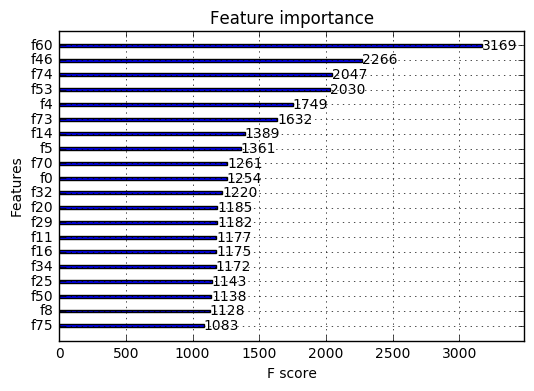

In [8]:
xgbst = xgb.Booster()
xgbst.load_model('./CV_0807_1.model')
plot_importance(xgbst, max_num_features=20)
plt.show()

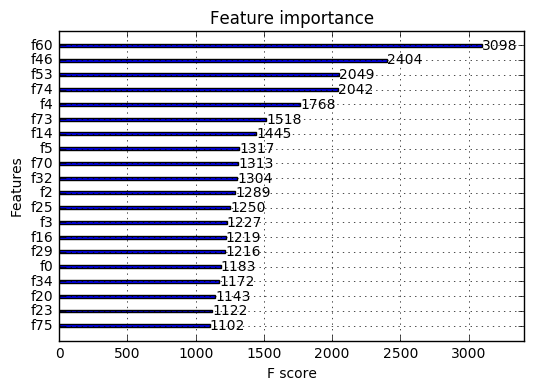

In [9]:
xgbst = xgb.Booster()
xgbst.load_model('./CV_0807_0.model')
plot_importance(xgbst, max_num_features=20)
plt.show()